Reference code by yoloe and ultralytics:  https://colab.research.google.com/drive/1y-r4y_owfFAfyqbqP2t64H7IqjURkKwe?usp=sharing#scrollTo=BSd93ZJzZZKt

ultralytics explanation: https://docs.ultralytics.com/models/yoloe/#getting-started

In [ ]:
# For transfering to custom dataset install from main branch of yoloe

# !pip install -q "git+https://github.com/THU-MIG/yoloe.git"

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from glob import glob
all_images = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/images/*'))
train_labels = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/labels/*'))
non_bg_images = sorted([os.path.basename(train_label)[:-4]+'.tif' for train_label in train_labels])
bg_images = sorted([os.path.basename(image_name) for image_name in all_images if os.path.basename(image_name) not in non_bg_images])

In [2]:
num_non_bg_image = 200
num_bg_image = 100

In [3]:
import shutil
import numpy as np

dynamic_dir = '../dynamic_train/images'
source_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/images'

if os.path.exists(dynamic_dir):
    shutil.rmtree(dynamic_dir)

if not os.path.exists(dynamic_dir):
    os.makedirs(dynamic_dir)

# creating symlink to non background images
for image_name in sorted(non_bg_images)[:num_non_bg_image]:
    source = os.path.join(source_path, image_name) 
    destination = os.path.join(dynamic_dir, image_name)
    os.symlink(src = source, dst = destination)

# creating symlink to background images
for image_name in sorted(bg_images)[:num_bg_image]:
    source = os.path.join(source_path, image_name) 
    destination = os.path.join(dynamic_dir, image_name)
    os.symlink(src = source, dst = destination)

dynamic_dir = '../dynamic_train/labels'
source_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/labels'

if os.path.exists(dynamic_dir):
    shutil.rmtree(dynamic_dir)

if not os.path.exists(dynamic_dir):
    os.makedirs(dynamic_dir)

# creating symlink to non background labels
for image_name in sorted(non_bg_images)[:num_non_bg_image]:
    source = os.path.join(source_path, image_name[:-4]+'.txt') 
    # bbox = np.loadtxt(source, ndmin = 2)
    # xmin = bbox[:,[1,3,5,7]].min(axis = 1)
    # xmax = bbox[:, [1,3,5,7]].max(axis = 1)
    # ymin = bbox[:,[2,4,6,8]].min(axis = 1)
    # ymax = bbox[:, [2,4,6,8,]].max(axis = 1)
    # width = xmax - xmin
    # height = ymax - ymin
    # xcenter = xmin + width / 2
    # ycenter = ymin + height / 2
    # bbox = np.array([bbox[:,0], xcenter, ycenter, width, height]).T
    destination = os.path.join(dynamic_dir, image_name[:-4]+'.txt')
    # np.savetxt(destination, bbox)
    os.symlink(source, destination)


In [4]:
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image

# fig, ax = plt.subplots()
# img = Image.open('/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/dynamic_train/images/8978754_3076282.tif')
# box = np.loadtxt('/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/dynamic_train/labels/8978754_3076282.txt', ndmin = 2)
# b = box[0]
# xc, yc, w, h = b[1:]*img.size[0]
# xmin = xc - w/2
# xmax = xc + w/2
# ymin = yc - h/2
# ymax = yc + h/2
# ax.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin])
# ax.imshow(img)

In [5]:
# True for Linear Probing and False for Full Tuning
# For fine tuning, YOLOE is exactly the same as YOLOv8 or YOLO11
USE_LINEAR_PROBING = True
project_name = "runs/lp" if USE_LINEAR_PROBING else "runs/ft"
lr0 = 1e-2 if USE_LINEAR_PROBING else 1e-3

In [ ]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.train_pe import YOLOEPETrainer, YOLOEPESegTrainer
from PIL import Image
import cv2
from ultralytics.nn.tasks import guess_model_scale
from ultralytics.utils import yaml_load, LOGGER
import torch

os.environ["PYTHONHASHSEED"] = "0"

data = "./yolo_data.yaml"

model = YOLOE("yoloe-v8l.yaml")
del model.model.model[-1].savpe
model.load("yoloe-v8l-seg.pt")
model.eval()

# Ensure pe is set for classes
names = yaml_load(data)['names']
print(names)
# You can also use text prompt embedding for labels
tpe = model.get_text_pe(names)
pe_path = "brick-kilns-pe.pt"
torch.save({"names": names, "pe": tpe}, pe_path) # save the model with text prompt embeddings

# # You can also use visual prompt embedding for labels
# SOURCE_IMAGE_PATHs = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/images/*'))

# source_images = []
# boxes = []
# classes = []

# for SOURCE_IMAGE_PATH in SOURCE_IMAGE_PATHs:
#     src_img_name = os.path.basename(SOURCE_IMAGE_PATH)
#     print(f'Source image name {src_img_name}')
#     # img = Image.open(SOURCE_IMAGE_PATH)
#     # size = img.size[0]
#     img = cv2.imread(SOURCE_IMAGE_PATH)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     size = img.shape[0]

#     label_path = f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/labels/{src_img_name[:-4]}.txt'
#     if os.path.exists(label_path):
#         bboxes = np.loadtxt(label_path, ndmin = 2)
#         cls = bboxes[:, 0]
#         # print(cls)
#         xmin = np.min(bboxes[:,[1,3,5,7]], axis = 1)
#         xmax = np.max(bboxes[:,[1,3,5,7]], axis = 1)
#         ymin = np.min(bboxes[:,[2,4,6,8]], axis = 1)
#         ymax = np.max(bboxes[:,[2,4,6,8]], axis = 1)
#         width = xmax - xmin
#         height = ymax - ymin
#         bboxes = np.array([xmin, ymin, xmin+width, ymin+height])
#         bboxes = bboxes.T
#         bboxes = bboxes * size
#         # print(bboxes)
#         cls = np.array([0 for _ in cls], dtype=np.int32)
#         source_images.append(img)
#         boxes.append(bboxes)
#         classes.append(cls)

# visuals = dict(bboxes=boxes[0], cls=classes[0]) 
# vpe = model.get_visual_pe(source_images[0], visuals)
# vpe_path = "brick-kilns-vpe.pt"
# torch.save({"names": names, "vpe": vpe}, vpe_path) # save the model with visual prompt embeddings

if USE_LINEAR_PROBING:
  head_index = len(model.model.model) - 1
  freeze = [str(f) for f in range(0, head_index)]
  for name, child in model.model.model[-1].named_children():
      if 'cv3' not in name:
          freeze.append(f"{head_index}.{name}")

  freeze.extend([f"{head_index}.cv3.0.0", f"{head_index}.cv3.0.1", f"{head_index}.cv3.1.0", f"{head_index}.cv3.1.1", f"{head_index}.cv3.2.0", f"{head_index}.cv3.2.1"])
else:
  freeze = None


In [ ]:
# Note that the printed parameters and FLOPS in YOLOe-v8l summary are not accurate because
# in YOLOe-v8l summary, the model is not reparameterized and the savpe of head is not removed.
# For the fine-tuned model, it is reparameterized and the savpe is removed, and it is exactly
# the same as YOLOv8-l, with zero overhead for fine tuning and inference.
results = model.train(data=data, epochs=100, close_mosaic=5, batch=32, imgsz = 320,
            optimizer='AdamW', lr0=lr0, warmup_bias_lr=0.0, \
            weight_decay=0.025, momentum=0.9, workers=4, \
            device="0", val_interval=1, project=project_name, \
            trainer=YOLOEPETrainer, freeze=freeze, train_pe_path=pe_path,
            save_conf=True, save_txt=True, save=True, val = True)

In [6]:
RUNS = f"{project_name}/train"

In [7]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!ls ./{RUNS}

args.yaml			 R_curve.png	     val_batch0_labels.jpg
confusion_matrix_normalized.png  results.csv	     val_batch0_pred.jpg
confusion_matrix.png		 results.png	     val_batch1_labels.jpg
F1_curve.png			 train_batch0.jpg    val_batch1_pred.jpg
labels				 train_batch1.jpg    val_batch2_labels.jpg
labels_correlogram.jpg		 train_batch2.jpg    val_batch2_pred.jpg
labels.jpg			 train_batch950.jpg  weights
P_curve.png			 train_batch951.jpg
PR_curve.png			 train_batch952.jpg


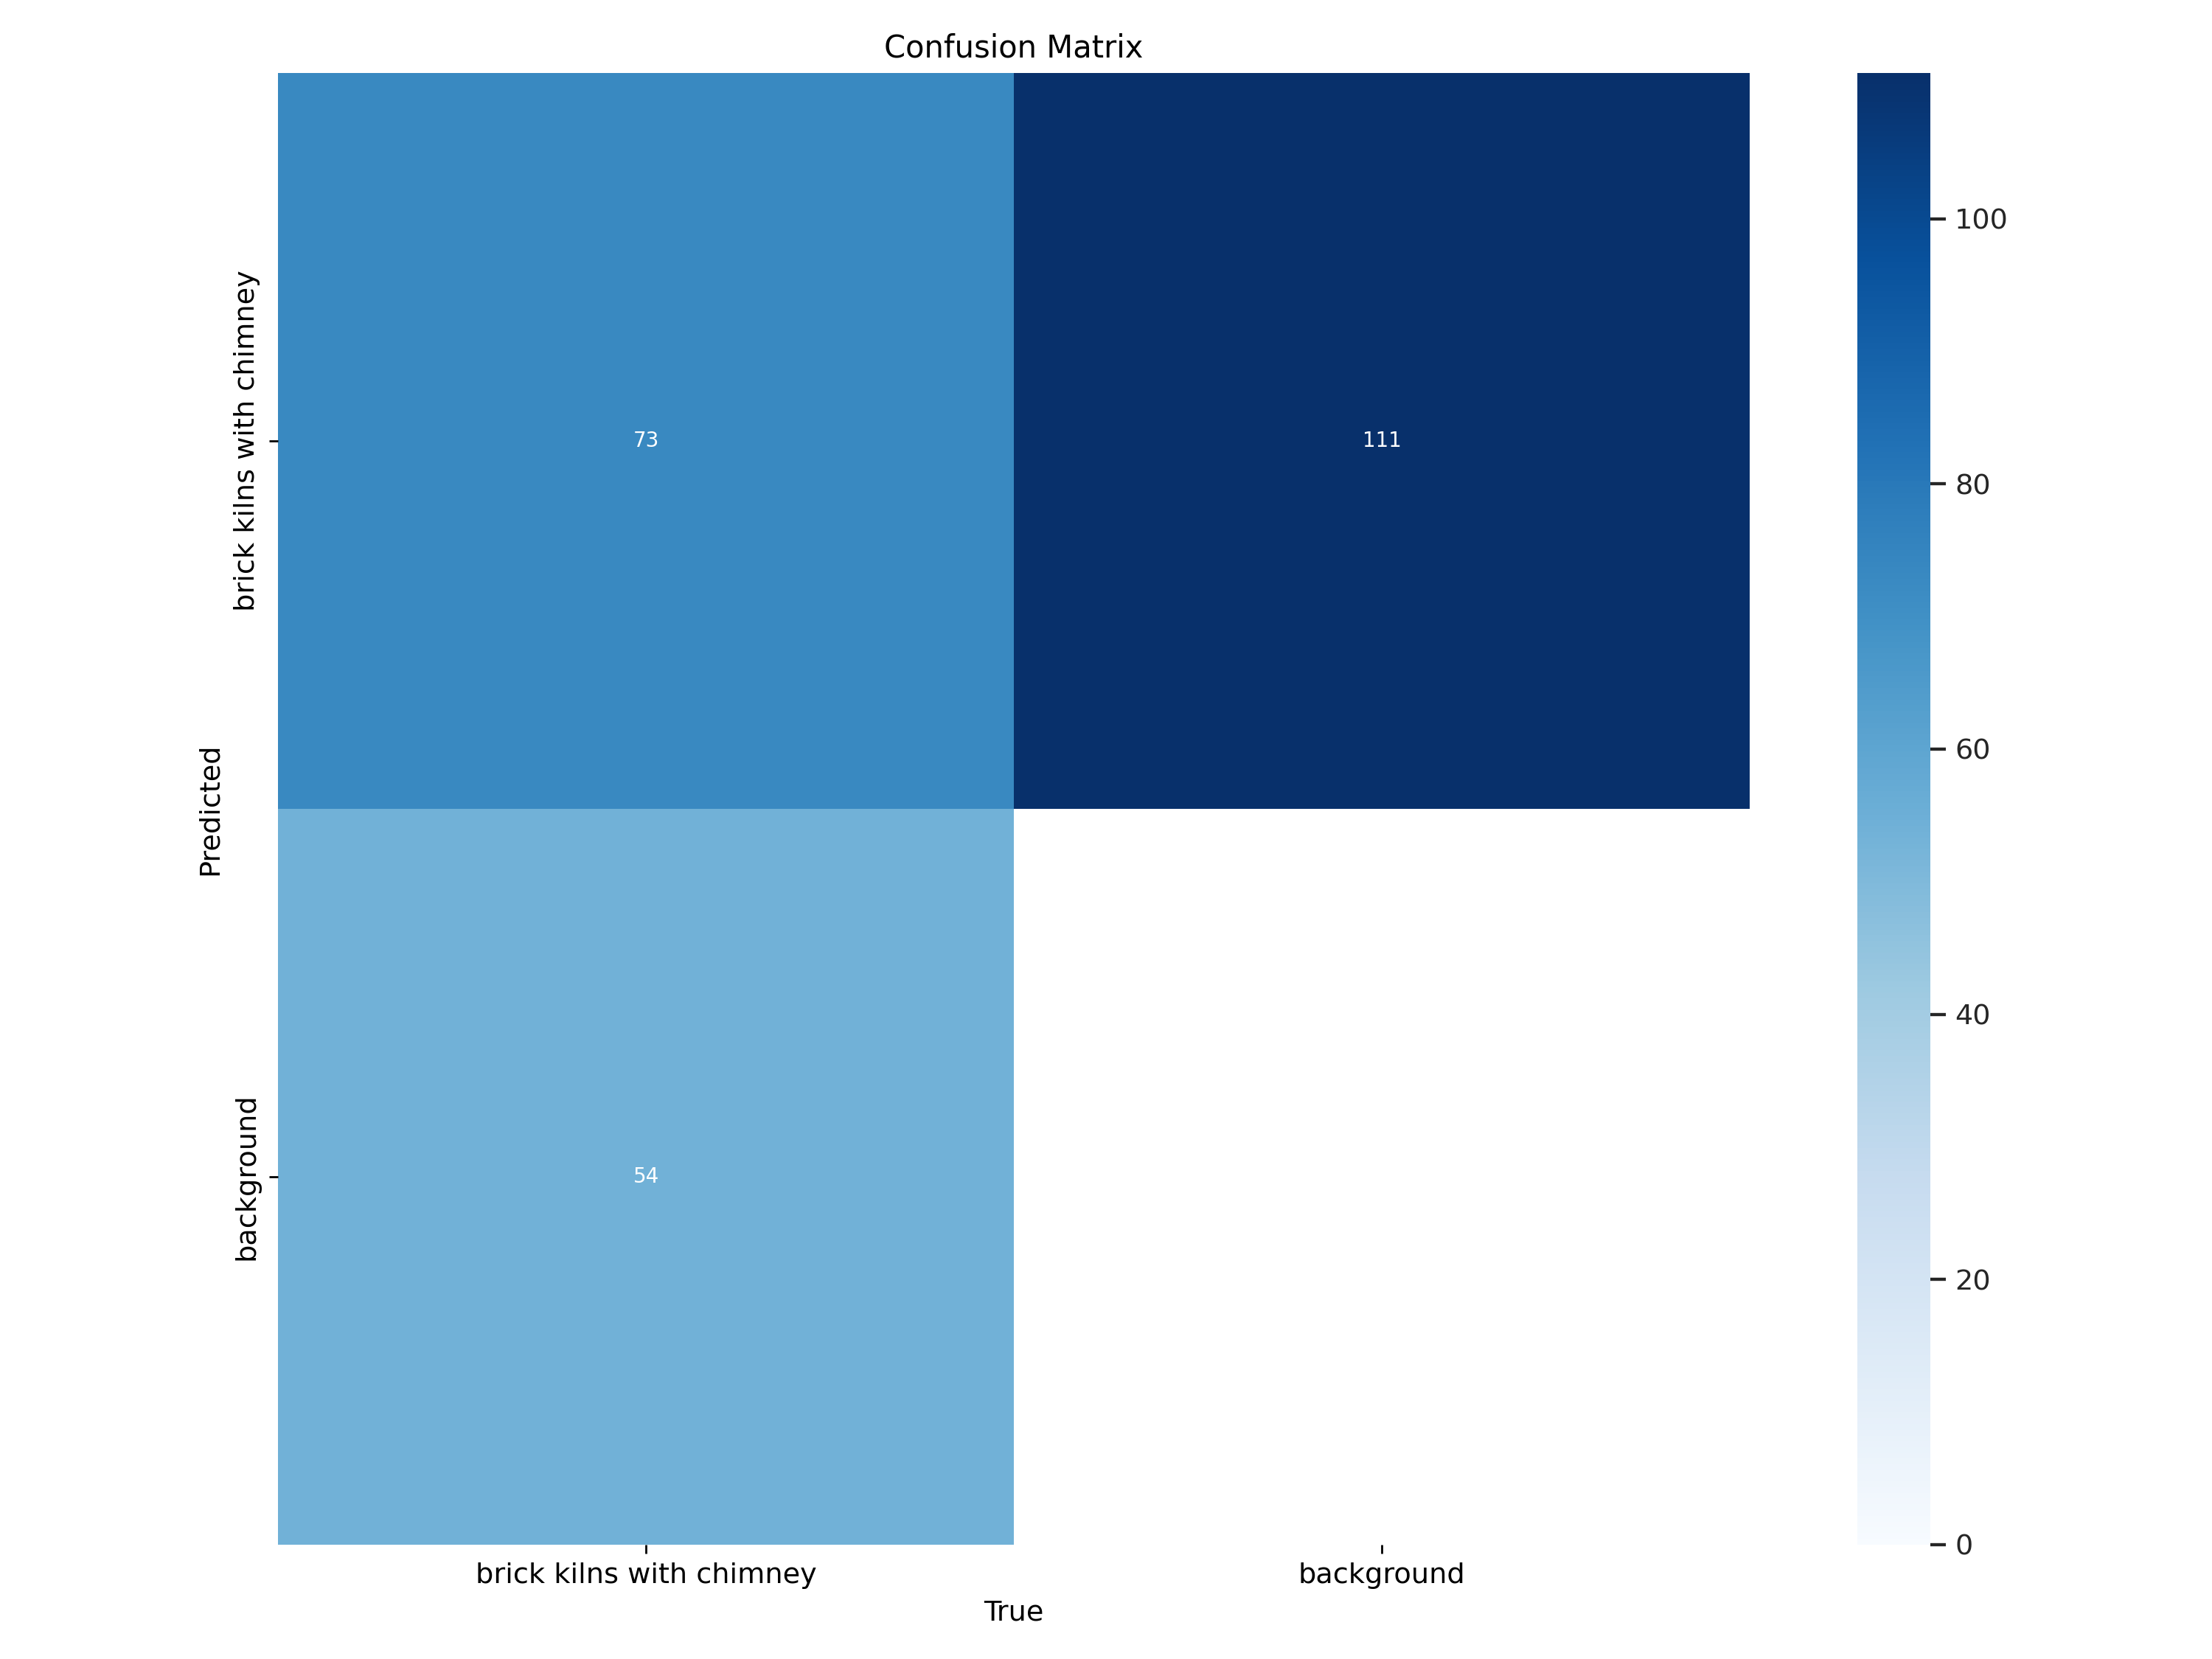

In [8]:
from IPython.display import Image
Image(filename=f'./{RUNS}/confusion_matrix.png', width=600)

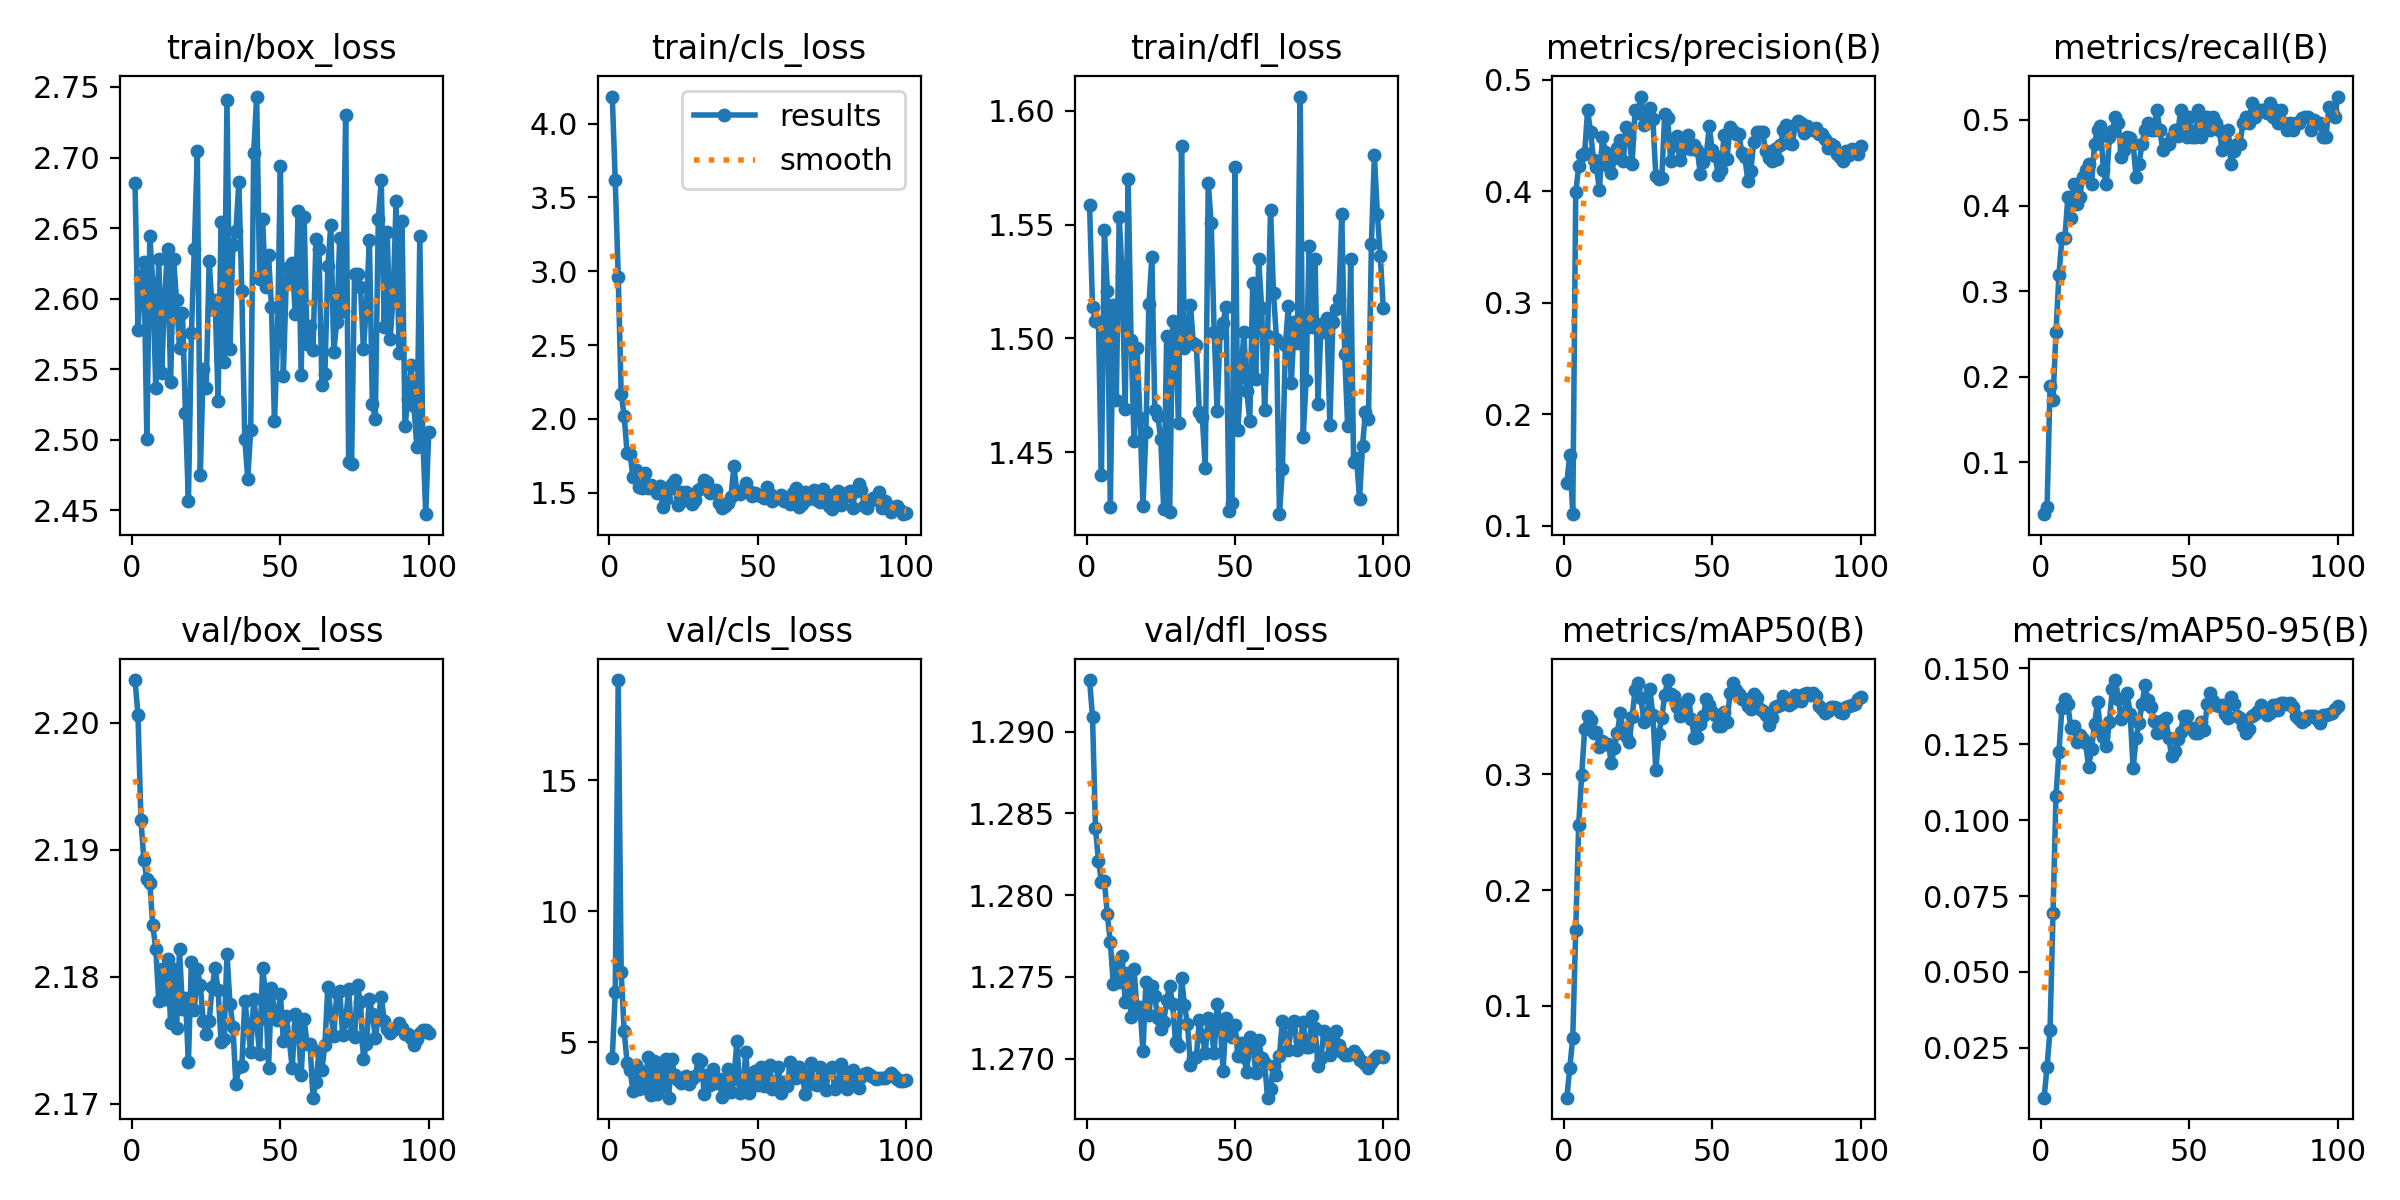

In [9]:
Image(filename=f'./{RUNS}/results.png', width=600)

In [10]:
from ultralytics import YOLOE, YOLO
import supervision as sv

model = YOLOE(f'./{RUNS}/weights/best.pt')
yolov8l = YOLO("yolov8l.yaml")

# After fine tuning, YOLOE is exactly the same as YOLOv8 or YOLO11
model.fuse()
# YOLOv8-L has more parameters because its nc is 80.
yolov8l.fuse()

YOLOe-v8l summary (fused): 273 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
YOLOv8l summary (fused): 268 layers, 43,668,288 parameters, 43,668,272 gradients, 165.2 GFLOPs


In [11]:
# from glob import glob
# import numpy as np

# label_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels'
# label_files = glob(label_path+'/*')
# for label_file in label_files:
#     bbox = np.loadtxt(label_file, ndmin = 2)
#     # print(bbox)
#     bbox[:, 0] = bbox[:, 0].astype(int)
#     # print(bbox)
#     np.savetxt(label_file, bbox, fmt = '%d %.6f %.6f %.6f %.6f %.6f %.6f %.6f %.6f')

In [12]:
# dataset = sv.DetectionDataset.from_yolo(
#     images_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/images",
#     annotations_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels",
#     data_yaml_path=f"./yolo_data.yaml",
#     is_obb = True, # label files are in obb format
# )


dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images",
    annotations_directory_path=f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/labels",
    data_yaml_path=f"./yolo_data.yaml",
    is_obb = True, # label files are in obb format
)

In [13]:
dataset.image_paths[:2]

['/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9789598_2528381.tif',
 '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9778591_2540611.tif']

In [14]:
dataset.annotations

{'/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9789598_2528381.tif': Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={}, metadata={}),
 '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9778591_2540611.tif': Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={}, metadata={}),
 '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9783483_2533273.tif': Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={}, metadata={}),
 '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9776145_2529604.tif': Detection

In [15]:
# img = Image.open('/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9782260_2532050.tif')
# annotation = dataset.annotations['/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/9782260_2532050.tif']
# annotation

In [16]:
import numpy as np
from PIL import Image
from tqdm import tqdm
predictions = []
targets = []

targets_d = []
predictions_d= []

for i in tqdm(range(len(dataset))):
    img_path = dataset.image_paths[i]
    image = Image.open(img_path)
    annotation = dataset.annotations[img_path]
    bbox = annotation.xyxy
    if len(bbox) == 0 :
        bbox = np.array([[0, 0, image.size[0], image.size[1], 1]]) # xmin ymin xmax ymax class 1 (background)
    else:
        bbox = np.hstack([bbox, np.zeros((len(bbox), 1))]) # xmin ymin xmax ymax class 0
    targets.append(bbox)
    targets_d.append(annotation)

    results = model.predict(source=image, conf=0.05)[0]
    detections = sv.Detections.from_ultralytics(results)
    bbox = detections.xyxy
    if len(bbox) == 0:
        bbox = np.array([[0, 0, image.size[0], image.size[1], 1, 1]]) # xmin ymin xmax ymax class 1 conf 1 (background)
    else:
        special = detections
        bbox = np.hstack([bbox, np.zeros((len(bbox), 1)),  detections.confidence.reshape(-1,1)]) # xmin, ymin, xmax, ymax, class 0, conf 
    predictions.append(bbox)
    predictions_d.append(detections)

  0%|          | 0/459 [00:00<?, ?it/s]


0: 320x320 (no detections), 13.0ms
Speed: 11.0ms preprocess, 13.0ms inference, 29.5ms postprocess per image at shape (1, 3, 320, 320)


  0%|          | 1/459 [00:14<1:49:55, 14.40s/it]


0: 320x320 (no detections), 10.9ms
Speed: 1.1ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 13.1ms
Speed: 0.9ms preprocess, 13.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 76.2ms postprocess per image at shape (1, 3, 320, 320)


  1%|▏         | 6/459 [00:14<13:36,  1.80s/it]  


0: 320x320 1 brick kilns with chimney, 12.1ms
Speed: 0.8ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.7ms
Speed: 0.5ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)


  3%|▎         | 13/459 [00:14<04:56,  1.51it/s]


0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.5ms preprocess, 8.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chim

  5%|▍         | 21/459 [00:14<02:25,  3.01it/s]


0: 320x320 (no detections), 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 12.4ms
Speed: 0.8ms preprocess, 12.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 13.7ms
Speed: 0.8ms preprocess, 13.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)


  6%|▌         | 28/459 [00:14<01:30,  4.78it/s]


0: 320x320 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess,

  8%|▊         | 36/459 [00:15<00:56,  7.50it/s]


0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.7ms
Speed: 0.5ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 13.7ms
Speed: 0.4ms preprocess, 13.7ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 320)


  9%|▉         | 43/459 [00:15<00:39, 10.57it/s]


0: 320x320 (no detections), 10.1ms
Speed: 0.8ms preprocess, 10.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 10.9ms
Speed: 0.7ms preprocess, 10.9ms

 11%|█         | 51/459 [00:15<00:27, 14.98it/s]


0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms


 13%|█▎        | 59/459 [00:15<00:19, 20.38it/s]


0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Sp

 15%|█▍        | 67/459 [00:15<00:14, 26.56it/s]


0: 320x320 (no detections), 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess

 16%|█▋        | 75/459 [00:15<00:11, 33.17it/s]


0: 320x320 16 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 

 18%|█▊        | 83/459 [00:15<00:09, 39.63it/s]


0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections)

 20%|█▉        | 91/459 [00:15<00:08, 45.64it/s]


0: 320x320 1 brick kilns with chimney, 13.0ms
Speed: 0.4ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms 

 22%|██▏       | 99/459 [00:15<00:07, 51.34it/s]


0: 320x320 (no detections), 12.9ms
Speed: 0.6ms preprocess, 12.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms

 23%|██▎       | 107/459 [00:16<00:06, 55.77it/s]


0: 320x320 (no detections), 14.5ms
Speed: 0.4ms preprocess, 14.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess

 25%|██▌       | 115/459 [00:16<00:05, 59.80it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.9ms
Speed: 0.4ms preprocess, 8.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.3ms
Speed: 0.4ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 

 27%|██▋       | 123/459 [00:16<00:05, 63.90it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 9 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chim

 29%|██▊       | 131/459 [00:16<00:04, 66.62it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms pr

 30%|███       | 139/459 [00:16<00:04, 68.99it/s]


0: 320x320 3 brick kilns with chimneys, 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 12.6ms
Speed: 0.8ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick

 32%|███▏      | 147/459 [00:16<00:04, 68.51it/s]


0: 320x320 (no detections), 14.7ms
Speed: 0.5ms preprocess, 14.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 12.8ms
Speed: 0.4ms preprocess, 12.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.3ms
Speed: 0.4ms preproce

 34%|███▍      | 155/459 [00:16<00:04, 68.64it/s]


0: 320x320 (no detections), 13.8ms
Speed: 0.8ms preprocess, 13.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 10.7ms
Speed: 0.4ms preprocess, 10.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0

 36%|███▌      | 163/459 [00:16<00:04, 68.63it/s]


0: 320x320 2 brick kilns with chimneys, 12.6ms
Speed: 0.6ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 9 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detecti

 37%|███▋      | 171/459 [00:16<00:04, 69.38it/s]


0: 320x320 (no detections), 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 9.3ms
Speed: 0.4ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms i

 39%|███▉      | 179/459 [00:17<00:03, 70.03it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess,

 41%|████      | 187/459 [00:17<00:03, 71.62it/s]


0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 9.3ms
Speed: 0.4ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Spee

 42%|████▏     | 195/459 [00:17<00:03, 72.08it/s]


0: 320x320 (no detections), 12.6ms
Speed: 0.6ms preprocess, 12.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.8ms
Speed: 0.8ms preprocess, 11.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preproc

 44%|████▍     | 203/459 [00:17<00:03, 70.87it/s]


0: 320x320 7 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.9ms
Speed: 0.4ms preprocess, 8.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (

 46%|████▌     | 211/459 [00:17<00:03, 71.62it/s]


0: 320x320 7 brick kilns with chimneys, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms

 48%|████▊     | 219/459 [00:17<00:03, 71.96it/s]


0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kiln

 49%|████▉     | 227/459 [00:17<00:03, 72.47it/s]


0: 320x320 (no detections), 9.0ms
Speed: 0.4ms preprocess, 9.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms infer

 51%|█████     | 235/459 [00:17<00:03, 73.60it/s]


0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detectio

 53%|█████▎    | 243/459 [00:17<00:02, 73.68it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.4ms
Speed: 0.4ms 

 55%|█████▍    | 251/459 [00:18<00:02, 74.22it/s]


0: 320x320 (no detections), 11.7ms
Speed: 0.4ms preprocess, 11.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4

 56%|█████▋    | 259/459 [00:18<00:02, 73.52it/s]


0: 320x320 (no detections), 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inf

 58%|█████▊    | 267/459 [00:18<00:02, 73.82it/s]


0: 320x320 2 brick kilns with chimneys, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick ki

 60%|█████▉    | 275/459 [00:18<00:02, 73.08it/s]


0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 11 brick kilns with chimneys, 8.5ms


 62%|██████▏   | 283/459 [00:18<00:02, 73.47it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 

 63%|██████▎   | 291/459 [00:18<00:02, 74.25it/s]


0: 320x320 1 brick kilns with chimney, 11.6ms
Speed: 0.4ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 10.2ms
S

 65%|██████▌   | 299/459 [00:18<00:02, 73.45it/s]


0: 320x320 (no detections), 9.1ms
Speed: 0.4ms preprocess, 9.1ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.5ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 10 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 

 67%|██████▋   | 307/459 [00:18<00:02, 72.95it/s]


0: 320x320 15 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 12 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4

 69%|██████▊   | 315/459 [00:18<00:01, 73.68it/s]


0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 9.5ms
Speed: 0.4ms preprocess, 9.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess

 70%|███████   | 323/459 [00:19<00:01, 73.53it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 12 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Sp

 72%|███████▏  | 331/459 [00:19<00:01, 73.73it/s]


0: 320x320 (no detections), 15.0ms
Speed: 0.6ms preprocess, 15.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 10.4ms
Speed: 0.6ms preprocess, 10.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 9 brick kilns with chimneys, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 9.7ms
Speed: 0.4ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detec

 74%|███████▍  | 339/459 [00:19<00:01, 71.03it/s]


0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 8 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimn

 76%|███████▌  | 347/459 [00:19<00:01, 72.03it/s]


0: 320x320 7 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms

 77%|███████▋  | 355/459 [00:19<00:01, 73.02it/s]


0: 320x320 (no detections), 11.2ms
Speed: 0.4ms preprocess, 11.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms

 79%|███████▉  | 363/459 [00:19<00:01, 73.14it/s]


0: 320x320 (no detections), 10.5ms
Speed: 0.6ms preprocess, 10.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inf

 81%|████████  | 371/459 [00:19<00:01, 73.37it/s]


0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 9 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.4ms
S

 83%|████████▎ | 379/459 [00:19<00:01, 73.96it/s]


0: 320x320 (no detections), 8.7ms
Speed: 0.4ms preprocess, 8.7ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8

 84%|████████▍ | 387/459 [00:19<00:00, 74.40it/s]


0: 320x320 4 brick kilns with chimneys, 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 9.5ms
Speed: 0.7ms preprocess, 9.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4

 86%|████████▌ | 395/459 [00:19<00:00, 73.01it/s]


0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 6 brick kilns with chimneys, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 

 88%|████████▊ | 403/459 [00:20<00:00, 73.88it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 3 brick kilns with chimneys, 8.5ms
Speed: 0.4ms p

 90%|████████▉ | 411/459 [00:20<00:00, 74.43it/s]


0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms p

 91%|█████████▏| 419/459 [00:20<00:00, 74.76it/s]


0: 320x320 1 brick kilns with chimney, 11.5ms
Speed: 0.4ms preprocess, 11.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 7 brick kilns with chimneys, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 10.9ms
Speed: 0.4ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 11.1ms
Speed: 0.6ms preprocess, 11.1ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no dete

 93%|█████████▎| 427/459 [00:20<00:00, 72.45it/s]


0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Spee

 95%|█████████▍| 435/459 [00:20<00:00, 73.27it/s]


0: 320x320 2 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 2 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.3ms
Speed: 0.4ms preprocess, 8.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.8ms
Speed: 0.4ms 

 97%|█████████▋| 443/459 [00:20<00:00, 73.92it/s]


0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 12 brick kilns with chimneys, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 4 brick kilns with chimneys, 8.4ms
Speed: 0.4ms preprocess

 98%|█████████▊| 451/459 [00:20<00:00, 74.56it/s]


0: 320x320 1 brick kilns with chimney, 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 5 brick kilns with chimneys, 11.8ms
Speed: 0.8ms preprocess, 11.8ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.5ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 1 brick kilns with chimney, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.5ms
Speed: 0.4ms preprocess, 8.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 320)

0: 320x320 (no detections), 8.4ms
Speed: 0.4ms

100%|██████████| 459/459 [00:20<00:00, 22.01it/s]


In [17]:
special.confidence

array([   0.058719], dtype=float32)

In [18]:
CLASSES = dataset.classes
CLASSES

['brick kilns with chimney']

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances
0,0.1,0.600985,0.463878,0.523605,122.0,81.0,141.0,263.0
0,0.3,0.571429,0.441065,0.497854,116.0,87.0,147.0,263.0
0,0.5,0.463054,0.357414,0.403433,94.0,109.0,169.0,263.0
0,0.7,0.211823,0.163498,0.184549,43.0,160.0,220.0,263.0




Plot of Confusion matrix at IoU 0.7


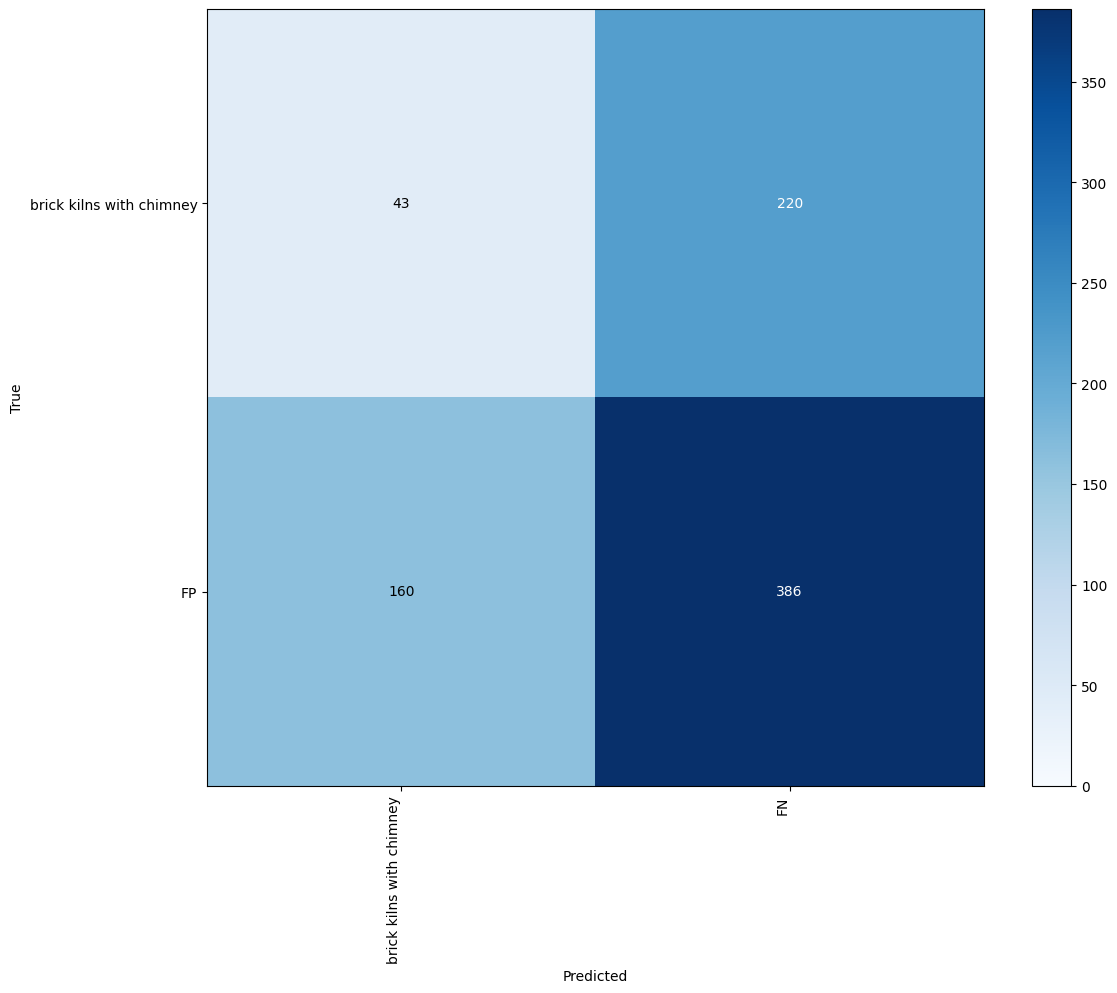

In [19]:
import pandas as pd
df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
for iou in [0.1,0.3,0.5,0.7]:
    confusion_matrix = sv.ConfusionMatrix.from_tensors(
        predictions=predictions,
        targets=targets,
        classes=CLASSES,    
        conf_threshold = 0.25, 
        iou_threshold=iou
    )

    # calculate precision recall and f1-score
    cm = confusion_matrix.matrix
    tp = cm[0][0]
    predicted_positives = cm[:,0].sum()
    actual_positives = cm[0, :].sum()
    precision = tp/ (predicted_positives + 1e-9)
    recall = tp/ (actual_positives + 1e-9)
    f1_score = 2*precision*recall / (precision + recall + 1e-9)
    false_positives = predicted_positives - tp

    df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])

display(df)

print(f'\n\nPlot of Confusion matrix at IoU {iou}')
_ = confusion_matrix.plot()

In [ ]:
from PIL import Image
from supervision.geometry.core import Position

annotated_images = []
for i in range(0,25):
    img_path = dataset.image_paths[i]
    image = Image.open(img_path)
    annotation = dataset.annotations[img_path]

    results = model.predict(source=image, conf=0.05)[0]
    detections = sv.Detections.from_ultralytics(results)

    annotated_image = sv.BoxAnnotator(thickness = 4, color=sv.Color(r=255, g=0, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(scene=image, detections=detections)
    annotated_image = sv.BoxAnnotator(thickness = 2, color=sv.Color(r=0, g=255, b=0), color_lookup=sv.ColorLookup.INDEX).annotate(scene=image, detections=annotation)
    # annotated_image = sv.LabelAnnotator(text_scale=1, text_thickness=1, text_position= Position.TOP_CENTER ,smart_position=True, color_lookup=sv.ColorLookup.INDEX).annotate(
    #     scene=annotated_image, detections=detections
    # )
    annotated_images.append(annotated_image)

%matplotlib inline
sv.plot_images_grid(annotated_images, (5,5))